In [1]:
'''
things to check

1. frequency of clusters
2. cluster transitions matrix
3. do people come back to previous clusters?
4. depths per cluster
5. 
'''

'\nthings to check\n\n1. frequency of clusters\n2. cluster transitions matrix\n3. do people come back to previous clusters?\n4. depths per cluster\n5. \n'

In [2]:
import pandas as pd
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import FancyArrowPatch
from IPython.display import HTML
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

/Users/surabhisnath/Nextcloud/Documents/PhD/Code/projects/process_modelling/.env/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [15]:
def plot_hist(arr, xlabel, ylabel, ax):
    ax.hist(arr, color="#d3c6f5")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

def get_sentence_transformer_embeddings(texts):
    """Extracts Text Embeddings using SentenceTransformer (model: gte-large)
    Args:
        texts (list): List of texts
    Returns:
        dict: Text and corresponding embedding
    """
    model = SentenceTransformer('thenlper/gte-large')
    embeddings = model.encode(texts)
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)         # normalise embeddings
    return dict(zip(texts, embeddings))

def get_clusters(embeddings, texts, cluster_assignment, printclusters):
    """Helper function for perform_hierarchicalClustering()
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        cluster_assignment (list): cluster assignment for each text/embedding
        printcluster (bool): True will print all texts in each cluster
    Returns:
        response_to_cluster dict: text to cluster number
        cluster_to_response dict: cluster number to list of texts in that cluster
        num_clusters int: number of clusters
        min_similarities dict: cluster to min text similiarity
    """

    cluster_to_response = defaultdict(list)                                 # make cluster_to_response
    cluster_to_embeddings = defaultdict(list)                               # make cluster_to_embeddings (used for min sim)
    for ind, cluster_num in enumerate(cluster_assignment):
        cluster_to_response[cluster_num].append(texts[ind])
        cluster_to_embeddings[cluster_num].append(embeddings[ind])
    
    response_to_cluster = dict(zip(texts, cluster_assignment))              # make response_to_cluster 
    
    num_clusters = len(np.unique(cluster_assignment))                       # find num clusters

    min_similarities = {}                                                   # find min paiwise text similarity in each cluster
    for cl in cluster_to_embeddings:
        stacked = np.array(cluster_to_embeddings[cl])
        sim = stacked @ stacked.T
        np.fill_diagonal(sim, np.inf)
        min_sim = np.min(sim)
        min_similarities[cl] = min_sim
    
    if printclusters:                                                       # print clusters if True
        for cluster_num, responses in cluster_to_response.items():
            print(f"Cluster {cluster_num}")
            print(responses, end="\n\n")

    return response_to_cluster, cluster_to_response, num_clusters, min_similarities

def perform_hierarchicalClustering(embeddings, texts, ax, cut_off_distance, printclusters):
    """Performs hierarchical clustering
    Args:
        embeddings (list): List of embeddings
        texts (list): List of texts
        ax: axes for plotting
        cut_off_distance (float): distance threshold for hierarchical clustering
        printcluster (bool): True will print all texts in each cluster
    Calls:
        get_clusters()
    """
    linked = linkage(embeddings, 'ward')                                                                                                    # 'ward' distance for measuring distance between clusters
    dendrogram(linked, orientation='top', labels=texts, distance_sort='descending', show_leaf_counts=False, no_labels=True, ax=ax[0])       # Make dendogram
    
    # Elbow plot -- Plot mean minsim/number of clusters as a fn of cut-off distance
    mean_minsemsim = []
    num_clusters = []
    for cod in np.linspace(1, 8, 30):
        cluster_assignment = fcluster(linked, t=cod, criterion='distance')
        _, _, _, minsims = get_clusters(embeddings, texts, cluster_assignment, False)
        mean_minsemsim.append(np.mean(list(minsims.values())))
        num_clusters.append(len(np.unique(cluster_assignment)))
    ax[1].plot(np.linspace(1, 8, 30), mean_minsemsim)
    ax[1].set_xlabel("Cut-off distance"); ax[1].set_ylabel("Mean cluster semantic similarity")
    ax[2].plot(np.linspace(1, 8, 30), num_clusters)
    ax[2].set_xlabel("Cut-off distance"); ax[2].set_ylabel("Number of clusters")

    cluster_assignment = fcluster(linked, t=cut_off_distance, criterion='distance')         # assign clusters using the decided cut_off_distance
    return get_clusters(embeddings, texts, cluster_assignment, printclusters)

def calculate_cosine_similarity(embedding1, embedding2):
    """Calculates cosine similarity between two embeddings
    Args:
        embedding1: first embedding
        embedding2: second embedding
    Returns:
        cosine similarity
    """
    if np.any(embedding1) and np.any(embedding2):
        return np.dot(embedding1, embedding2)
    else:
        return 0

def plot_movement(cluster_order, pid, ax, num_points = 18):
    # Calculate the positions of the equidistant points on the circle
    theta = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x = 1.5 * np.cos(theta)
    y = 1.5 * np.sin(theta)

    # Adjust the cluster_order to be zero-indexed
    cluster_order = [p-1 for p in cluster_order]

    # Create the figure and axis
    ax.set_aspect('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.axis('off')

    # Annotate the points with their numbers
    for i in range(num_points):
        ax.text(x[i], y[i], str(i + 1), fontsize=12, ha='center', va='center', c="r")

    # Define a colormap
    cmap = plt.get_cmap('viridis')

    # Draw lines and arrows
    for i in range(len(cluster_order) - 1):
        start = (x[cluster_order[i]], y[cluster_order[i]])
        end = (x[cluster_order[i + 1]], y[cluster_order[i + 1]])
        
        # Get the color from the colormap
        color = cmap(i / (len(cluster_order) - 1))
        if start[0] == end[0] and start[1] == end[1]:
            ax.plot(start[0], start[1], 'o', c=color)
            continue
        
        # Draw the line with the assigned color
        ax.plot([start[0], end[0]], [start[1], end[1]], color=color)
        
        # Calculate the midpoint for the arrow
        mid = ((start[0] + end[0]) / 2, (start[1] + end[1]) / 2)
        direction = (end[0] - start[0], end[1] - start[1])
        length = np.hypot(direction[0], direction[1])
        direction = (direction[0] / length, direction[1] / length)
        
        # Draw the arrow at the midpoint
        arrow = FancyArrowPatch((mid[0] - direction[0] * 0.15, mid[1] - direction[1] * 0.15),
                                (mid[0] + direction[0] * 0.15, mid[1] + direction[1] * 0.15),
                                color=color, arrowstyle='-|>', mutation_scale=15)
        ax.add_patch(arrow)

    # Show the final static image
    ax.set_title(f"\nParticipant {pid}\n")

In [16]:
cluster_to_animals = {
    1: ["aardvark", "ankole", "antelope", "aoudad", "blesbok", "bontebok", "buffalo", "bushbaby", "bushbuck", "bushpig", "camel", "caracal", "chameleon", "cheetah", "chimpanzee", "civet", "cliffchat", "cobra", "colobus", "cusimanse", "dassie", "dikdik","duiker", "eland", "elephant", "fennecfox", "gazelle", "gemsbok", "genet", "gerenuk", "giraffe", "gnu", "gorilla", "hartebeest", "hippopotamus", "hyena", "hyrax", "impala", "jackal", "jerboa", "klipspringer", "kob", "kongoni", "koodoo", "kudu", "lechwe", "lemur", "leopard", "lion", "lioness", "lourie", "lovebird", "manatee", "mandrill", "meerkat", "mongoose", "monkey", "mousebird", "nyala", "okapi", "oribi", "oryx", "ostrich", "panther", "puku", "quagga", "reedbuck", "rhino", "rhinoceros", "serval", "sifaka", "springbok", "springhare", "steenbok", "steenbuck", "sunbird", "sungazer", "suricate", "tiger", "topi", "tsessebe", "warthog", "waterbuck", "wildebeest", "zebra", "zorilla"],
    2: ["alpaca", "beaver", "chamois", "chinchilla", "ermine", "fox", "llama", "mink", "rabbit", "sable", "vicuna"],
    3: ["arcticfox", "auk", "caribou", "muskox", "penguin", "polarbear", "reindeer", "seal", "sheathbill", "walrus", "woollymammoth"],
    4: ["bandicoot", "corella", "devil", "dingo", "duckbill", "dunnart", "emu", "galah", "kangaroo", "kiwi", "koala", "macropod", "malleefowl", "numbat", "pademelon", "platypus", "opossum", "possum", "potoroo", "quoll", "sugar", "sugarglider", "tasmaniandevil", "wallaby", "wallaroo", "wambenger", "wombat", "woylie"],
    5: ["ass", "burro", "camel", "colt", "donkey", "dromedary", "horse", "llama", "mare", "mule", "mustang", "ox", "pony", "trotter", "yak"],
    6: ["albatross", "avian", "avocet", "bird", "bittern", "blackbird", "bluebird", "bluefootedbooby", "bluegill", "bluejay", "bobolink", "booby", "boubou", "bulbul", "bullfinch", "bunting", "Bustard", "buzzard", "canary", "cardinal", "cassowary", "chickadee", "chicken", "cliffchat", "cock", "cockatiel", "cockatoo", "conure", "corella", "cormorant", "crake", "crow", "cuckoo", "curassow", "dabchick", "darter", "dikkop", "dodo", "dove", "drake", "duck", "duckling", "eagle", "eaglet", "egret", "emu", "ewe", "falcon", "finch", "flamingo", "fowl", "francolin", "frogmouth", "galah", "gallinule", "gander", "goldfinch", "gonolek", "goshawk", "gosling", "grebe", "greenfinch", "grosbeak", "grouse", "guineafowl", "gull", "gyrfalcon", "hammerkop", "harrier", "hawk", "heron", "honeyeater", "hornbill", "hummingbird", "ibis", "jackdaw", "jay", "kestrel", "kingfisher", "kite", "kiwi", "kookaburra", "lark", "laughingthrush", "loon", "lorikeet", "lory", "lourie", "lovebird", "macaw", "magpie", "mallard", "malleefowl", "marshbird", "meadowlark", "merganser", "merlin", "mockingbird", "moorhen", "motmot", "mouse", "mousebird", "myna", "nightingale", "openbill", "oriole", "osprey", "ostrich", "owl", "parakeet", "parrot", "partridge", "peacock", "peafowl", "pelican", "penguin", "peregrine", "pheasant", "pigeon", "pintail", "pitta", "plover", "puffin", "quail", "quetzal", "rail", "raven", "rhea", "roadrunner", "robin", "rook", "sandgrouse", "sandpiper", "seagull", "seriema", "sheathbill", "shelduck", "shoveler", "shrike", "siskin", "skylark", "snipe", "songbird", "sparrow", "spoonbill", "spurfowl", "starling", "stilt", "stork", "sunbird", "sunbittern", "swallow", "swallowtail", "swan", "swift", "tanager", "teal", "thrush", "tinamou", "titmouse", "toucan", "tragopan", "trumpeter", "turaco", "turkey", "umbrellabird", "vulture", "warbler", "waxbill", "weaver", "wigeon", "wildfowl", "woodpecker", "wren"],
    7: ["ankole", "antilope", "aoudad", "bison", "blesbok", "bontebok", "buffalo", "bullock", "bushbock", "calf", "cattle", "cow", "dik dik", "gemsbok", "gerenuk", "hartebeest", "heifer", "ibex", "klipspringer", "kob", "monitor", "muskox", "nilgai", "nyala", "oribi", "pronghorn", "puku", "reedbuck", "springbok", "steenbuck", "steer", "topi", "tsessebe", "water buffalo", "waterbuck", "yak", "zebu"],
    8: ["akita", "barbet", "blacklab", "bloodhound", "bulldog", "canine", "chihuahua", "coati", "coatimundi", "coyote", "dachshund", "dalmatian", "dog", "fox", "golden retriever", "great dane", "greyhound", "grison", "harrier", "husky", "hyena", "jackal", "labrador retriever", "malamute", "pembroke welsh corgi", "poodle", "pug", "puggle", "pup", "shihtzu", "siberian husky", "terrier", "timber wolf", "wild dog", "wolf"],
    9: ["blacktailed deer", "brocket", "buck", "caribou", "chital", "deer", "doe", "eland", "elk", "fawn", "gazelle", "gnu", "impala", "moose", "muledeer", "muntjac", "reindeer", "roe", "sambar", "stag", "wapiti", "whitetailed deer", "wildebeest"],
    10: ["ass", "billygoat", "bronco", "bullock", "calf", "chick", "chicken", "cock", "colt", "cow", "donkey", "ferret", "foal", "goat", "heifer", "hen", "hog", "horse", "kid", "lamb", "mare", "miniature pony", "mule", "pig", "piglet", "pony", "potbellied pig", "ram", "rabbit", "rooster", "sheep", "snake", "sow", "spider", "stallion", "turkey"],
    11: ["bengal tiger", "bobcat", "bull", "cat", "caracal", "cheetah", "civet", "cougar", "crane", "jaguar", "jaguarundi", "leopard", "leopardess", "liger", "lion", "lynx", "margay", "mountainlion", "ocelot", "panther", "puma", "ring tailed cat", "serval", "siamese cat", "snow leopard", "snow lion", "tiger", "tigress", "tomcat", "whitetiger", "wildcat"],
    12: ["fisher", "angelfish", "arrowheadshark", "balloonfish", "barracuda", "bass", "betta", "blacktipreefshark", "blowfish", "carp", "catfish", "cavefish", "cichlids", "clownfish", "cuttlefish", "dragonet", "filefish", "fish", "flounder", "freshwater fish", "goldfish", "great white shark", "grenadier", "grouper", "grunt", "guppy", "herring", "jack", "knifefish", "koi", "lamprey", "lionfish", "lookdown", "mackerel", "mako shark", "minnow", "moray", "pacu", "parrotfish", "pike", "pink salmon", "piranha", "pleco", "porkfish", "pufferfish", "rainbowfish", "sailfish", "salmon", "saltwater fish", "scorpionfish", "seabass", "shark", "shrimp", "smelt", "stickleback", "stonefish", "sturgeon", "swordfish", "tang", "tetra", "tilapia", "triplefin", "trout", "tuna", "whale shark"],
    13: ["aardvark", "anteater", "armadillo", "bat", "bittern", "echidna", "hedgehog", "jumpingspider", "mole", "shrew", "spiderling", "sugar"],    
    14: ["ant", "antlion", "aphid", "bee", "beetle", "blackwidow", "bug", "butterfly", "caterpillar", "centipede", "cicada", "cockroach", "cricket", "daddy long legs", "dragonfly", "earthworm", "flea", "fly", "gnat", "grasshopper", "grub", "honeybee", "hornet", "insect", "June beetle", "ladybug", "larva", "leafy", "louse", "lubber", "maggot", "mealworm", "mite", "monarch butterfly", "mosquito", "moth", "pill bug", "praying mantis", "scorpion", "silkworm", "stick insect", "tarantula", "termite", "tick", "wasp", "worm", "yellow jacket"],
    15: ["antelope", "badger", "bear", "beaver", "bighorn", "bighorn", "bison", "blackbear", "boar", "bobcat", "brownbear", "caribou", "chipmunk", "chuckwalla", "cornsnake", "cottonmouth", "cougar", "coyote", "cub", "deer", "drongo", "elk", "fox", "grizzly bear", "kodiak bear", "moose", "mountaingoat", "mountainlion", "pronghorn", "puma", "rabbit", "raccoon", "skunk", "squirrel", "titmouse", "vaquita", "weasel", "wolf"],
    16: ["budgie", "canary", "cat", "cockatiel", "cockatoo", "dog", "gerbil", "goldenretriever", "goldfish", "guineapig", "guppy", "hamster", "kitten", "labradorretriever", "malamute", "parakeet", "parrot", "poodle", "puppy", "rabbit"],
    17: ["ape", "baboon", "bonobo", "capuchin", "chimpanzee", "colobus", "gibbon", "gorilla", "howler monkey", "human", "langur", "lemur", "loris", "macaque", "mandrill", "marmoset", "monkey", "orangutan", "primates", "saki monkey", "shrew", "siamang", "sifaka", "snow monkey", "spider monkey", "tamarin", "titi"],
    18: ["bunny", "coney", "hare", "jackrabbit", "rabbit"],
    19: ["adder", "alligator", "amphibian", "anaconda", "anole", "asp", "basilisk", "black mamba", "boaconstrictor", "bullfrog", "caiman", "chameleon", "chuckwalla", "cobra", "constrictor", "cornsnake", "cottonmouth", "crocodile", "diamondback", "dinosaur", "dragon", "frog", "garden snake", "gecko", "godzilla", "iguana", "kingsnake", "komododragon", "lizard", "milksnake", "moccasin", "newt", "pit viper", "python", "ratsnake", "rattlesnake", "reptile", "salamander", "serpent", "sidewinder", "skink", "snake", "sungazer", "toad", "tomistoma", "tortoise", "tree frog", "turtle", "velociraptor", "viper", "watersnake"],
    20: ["agouti", "beaver", "blacksquirrel", "capybara", "cavy", "chinchilla", "chipmunk", "degu", "dormouse", "flyingsquirrel", "gerbil", "goldenmarmot", "gopher", "groundhog", "guineapig", "hamster", "hedgehog", "lemming", "marmot", "mole", "mouse", "muskrat", "naked mole rat", "phascogale", "porcupine", "potoroo", "prairie dog", "rat", "rodent", "shrew", "springhare", "squirrel", "vole", "woodchuck", "woylie"],
    21: ["alga", "alligator", "anemone", "axolotl", "baiji", "balloonfish", "beaver", "beluga", "blacktipreefshark", "bluewhale", "boto", "brineshrimp", "cavefish", "cichlids", "clam", "conch", "coral", "cowry", "crab", "crawfish", "crayfish", "dogfish", "dolphin", "dragonet", "dugong", "eel", "elephant seal", "filefish", "fish", "frog", "goose", "hammerhead shark", "humpback whale", "jellyfish", "killer whale", "knifefish", "leech", "limpet", "lionfish", "lobster", "lookdown", "manatee", "mantaray", "moray", "murex", "muskrat", "mussel", "narwhal", "nautilus", "newt", "octopus", "orca", "otter", "oyster", "pacu", "penguin", "platypus", "pleco", "porkfish", "porpoise", "prawn", "pufferfish", "ray", "sailfish", "salamander", "sanddollar", "sawfish", "scallop", "scorpionfish", "sealion", "seamonkey", "seahorse", "seal", "shark", "slug", "snail", "sponge", "squid", "starfish", "stingray", "stonefish", "tadpole", "tang", "tetra", "toad", "triplefin", "turtle", "urchin", "vaquita", "whale"],
    22: ["badger", "ferret", "groundhog", "marten", "mink", "mongoose", "otter", "polecat", "seaotter", "skunk", "stoat", "weasel", "wolverine"]
}

animal_to_clusters = {}
for key, value_list in cluster_to_animals.items():
    for value in value_list:
        if value not in animal_to_clusters:
            animal_to_clusters[value] = [key]
        else:
            animal_to_clusters[value].append(key)

In [17]:
df = pd.read_csv("../csvs/data.csv")
df["pid"] = pd.factorize(df['sid'])[0]
df["clusters"] = df["entry"].map(animal_to_clusters)
df['previous_entry'] = df['entry'].shift(1)
df["order"] = np.concatenate([np.arange(i) for i in df.groupby("pid").count()["entry"].tolist()])    # order variable per ppt x task. Starts from 0
df.loc[df["order"] == 0, "previous_entry"] = None

In [18]:
animals = df["entry"].unique().tolist()
filename = "sentence_transformer_embeddings_animals_gtelarge"
try:
    sentence_transformer_embeddings = pk.load(open(f"../embeddings/{filename}.pk", "rb"))
except:
    sentence_transformer_embeddings = get_sentence_transformer_embeddings(animals)
    pk.dump(sentence_transformer_embeddings, open(f"../embeddings/{filename}.pk", "wb"))

In [19]:
num_categories = 22
num_participants = len(df["sid"].unique())

## Statistics

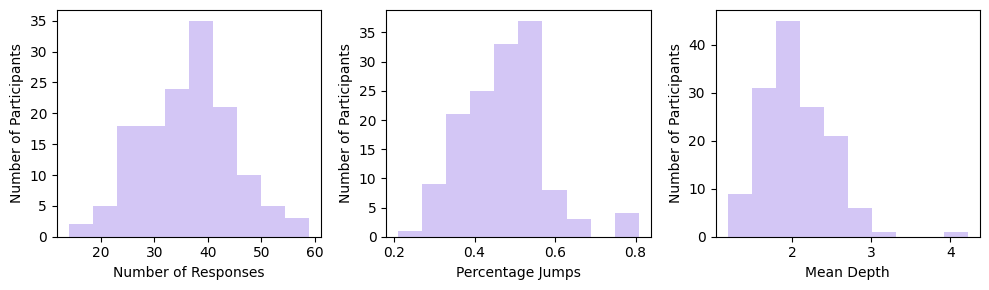

In [20]:
fig, ax = plt.subplots(1,3, figsize=(10,3))
plot_hist(df.groupby("pid").count()["entry"], "Number of Responses", "Number of Participants", ax[0])
plot_hist(df.groupby("pid").sum()["flastitem"].to_numpy()/df.groupby("pid").count()["entry"].to_numpy(), "Percentage Jumps", "Number of Participants",  ax[1])

def mean_depth(group):
    reset_points = list(group[group['fpatchitem'] == 1].index) + [int(group.index[-1]) + 1]
    segment_lengths = np.array(pd.Series(reset_points).diff().tolist()[1:])
    return segment_lengths.mean()
plot_hist(df.groupby('pid').apply(mean_depth).tolist(), "Mean Depth", "Number of Participants",  ax[2]);
plt.tight_layout()

In [9]:
df[df["clusters"].isnull()]

,sid,entry,irt,fpatchnum,fpatchitem,fitemsfromend,flastitem,meanirt,catitem,pid,clusters,previous_entry,order
56,71,raptor,5,10,1,1,1,4.842105,22,1,NaN,bluebird,21
143,285,whitetaileddeer,9,1,7,2,0,4.842105,7,4,NaN,muledeer,6
144,285,blacktaileddeer,5,1,8,1,1,4.842105,8,4,NaN,whitetaileddeer,7
145,285,grizzly,7,2,1,4,0,4.842105,9,4,NaN,blacktaileddeer,8
148,285,kodiakbear,5,2,4,1,1,4.842105,12,4,NaN,brownbear,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950,998,sloth,7,8,1,1,1,4.615385,23,137,NaN,kangaroo,22
4957,998,grizzly,7,11,1,4,0,4.615385,30,137,NaN,dolphin,29
5001,1098,sloth,5,6,1,1,1,4.842105,9,139,NaN,shark,8
5068,1099,sloth,3,24,1,1,1,4.020408,39,140,NaN,lemur,38


Cluster 3
['cat', 'lion', 'panther', 'badger', 'raccoon', 'bobcat', 'beaver', 'wolf', 'coyote', 'seal', 'kitten', 'jaguar', 'lioness', 'cougar', 'ocelot', 'otter', 'lynx', 'leopard', 'wildcat', 'sealion', 'siamesecat']

Cluster 7
['dog', 'labradorretriever', 'puggle', 'puppy', 'prairiedog', 'porpoise', 'puma', 'malamute', 'greyhound', 'bloodhound', 'porcupine', 'poodle', 'terrier']

Cluster 8
['mouse', 'rat', 'ostrich', 'aardvark', 'hippopotamus', 'shark', 'hamster', 'squirrel', 'muskrat', 'skunk', 'opossum', 'groundhog', 'possum', 'chipmunk', 'gerbil', 'mountaingoat', 'billygoat', 'warthog', 'chinchilla', 'yak', 'ram', 'komododragon', 'mammal', 'jackrabbit', 'platypus', 'liger', 'dinosaur', 'dalmation', 'armadillo', 'siberianhusky', 'woodpecker', 'woodchuck', 'hedgehog', 'capybara', 'tapir', 'akita', 'shihtzu', 'axolotl', 'stork']

Cluster 6
['giraffe', 'zebra', 'meerkat', 'ferret', 'monkey', 'hyena', 'cheetah', 'gazelle', 'orangutan', 'gorilla', 'chimpanzee', 'antelope', 'sloth', 'an

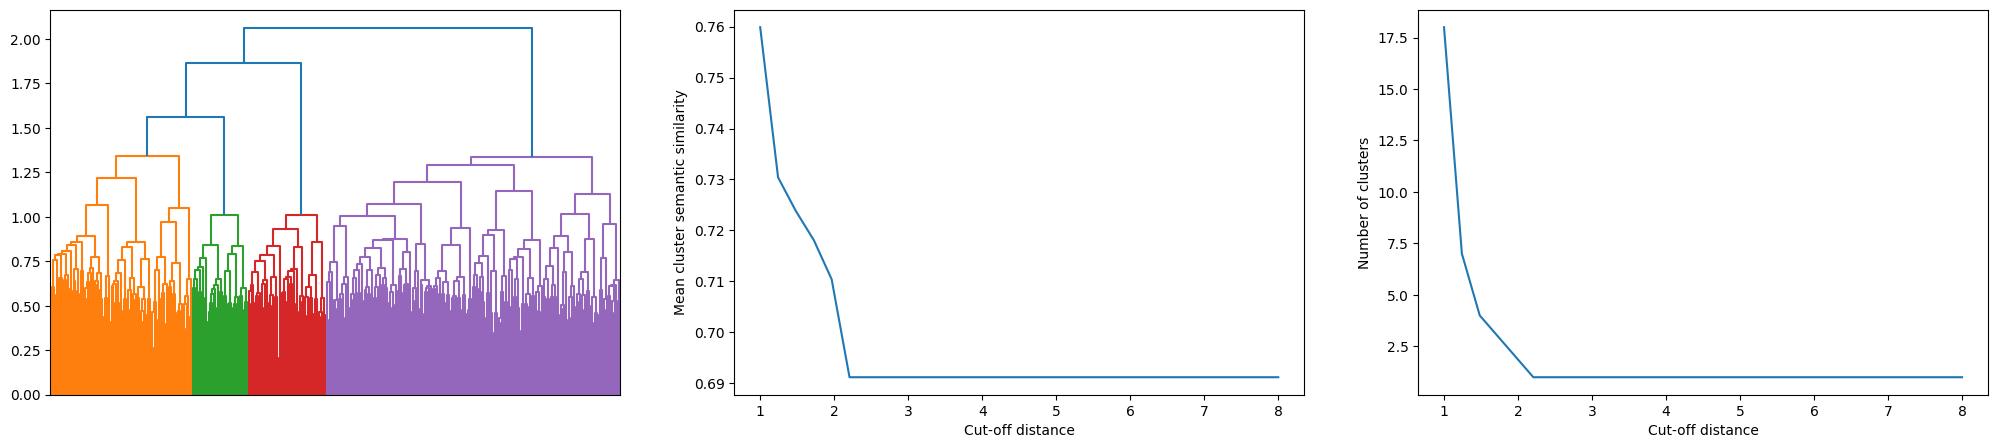

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
response_to_cluster, cluster_to_response, num_clusters, minsim = perform_hierarchicalClustering([sentence_transformer_embeddings[x] for x in animals], animals, ax, 1, True)
print("Num clusters =", num_clusters)
print(np.min(list(minsim.values())), np.mean(list(minsim.values())))

In [11]:
def write_category_SS_jump_filterorder0(data):
    # write category using response_to_cluster
    data["category"] = data["entry"].apply(lambda x: response_to_cluster.get(x))

    data['SS'] = data.apply(lambda row: calculate_cosine_similarity(sentence_transformer_embeddings.get(row['entry']), sentence_transformer_embeddings.get(row['previous_entry'])), axis=1)
    
    data["category"] = data["category"].astype(int)
    data["jump_cat"] = (~(data["category"].diff() == 0)).astype(int)
    data["jump_SS"] = (data["SS"] < 0.81).astype(int)
    # data['jump'] = data["jump_cat"] & data["jump_SS"]
    data['jump'] = data["jump_cat"]


    data = data[data["order"] > 0]      # remove the first response

    return data

df = write_category_SS_jump_filterorder0(df)

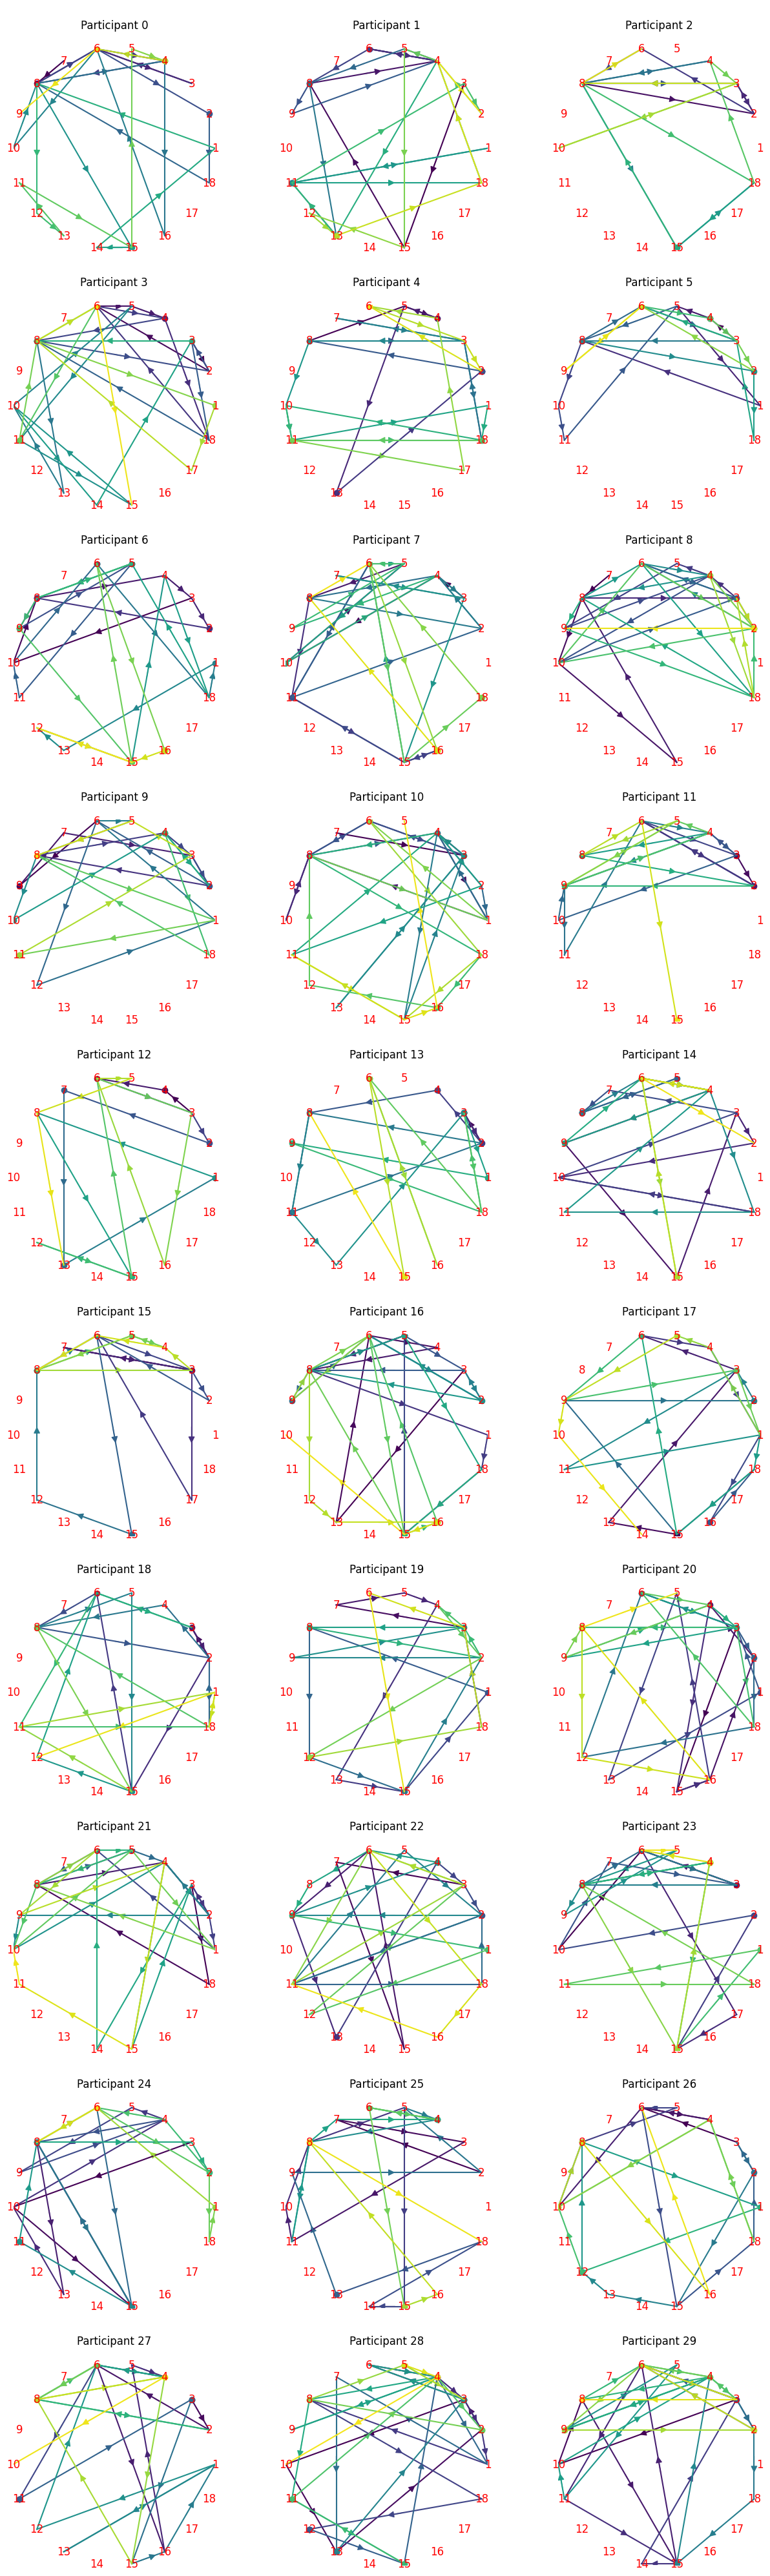

In [12]:
fig, ax = plt.subplots(10, 3, figsize=(13,40))
for pid in range(30):
    plot_movement(df[df["pid"] == pid]["category"].tolist(), pid, ax[pid//3, pid%3])
plt.tight_layout()
plt.show()

In [13]:
df

,sid,entry,irt,fpatchnum,fpatchitem,fitemsfromend,flastitem,meanirt,catitem,pid,clusters,previous_entry,order,category,SS,jump_cat,jump_SS,jump
1,51,dog,3,1,2,1,1,5.200000,2,0,"[8, 16]",cat,1,7,0.822752,1,0,1
2,51,mouse,3,2,1,2,0,5.200000,3,0,"[6, 20]",dog,2,8,0.824710,1,0,1
3,51,rat,3,2,2,1,1,5.200000,4,0,[20],mouse,3,8,0.852002,0,0,0
4,51,giraffe,6,3,1,7,0,5.200000,5,0,[1],rat,4,6,0.764132,1,1,1
5,51,lion,2,3,2,6,0,5.200000,6,0,"[1, 11]",giraffe,5,3,0.825510,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5074,1099,whale,2,27,3,4,0,4.020408,45,140,[21],manatee,44,1,0.851609,0,0,0
5075,1099,seal,2,27,4,3,0,4.020408,46,140,"[3, 21]",whale,45,3,0.810950,1,0,1
5076,1099,polarbear,3,27,5,2,0,4.020408,47,140,[3],seal,46,2,0.785275,1,1,1
5077,1099,snowfox,3,27,6,1,1,4.020408,48,140,NaN,polarbear,47,17,0.813255,1,0,1


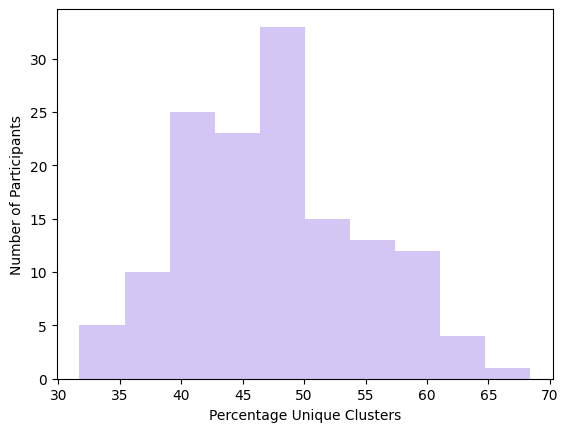

In [14]:
plt.hist(df[["pid", "category", "jump"]].groupby("pid").nunique()["category"] / (df[["pid", "category", "jump"]].groupby("pid").sum()["jump"] + 1) * 100, color="#d3c6f5")
plt.xlabel("Percentage Unique Clusters")
plt.ylabel("Number of Participants");